In [176]:
%matplotlib inline

from abtem import __version__
print('current version:', __version__)

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import matplotlib.pyplot as plt

from ase.visualize import view

from abtem import *

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as c
from abtem.transfer import scherzer_defocus
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 20)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

from abtem.utils import fft_shift

from abtem.aperture import DeviatedAnularAperture

current version: 1.0.0beta27


In [2]:
def imshow_direct(X, *args, **kwargs): 
    return plt.imshow(X=np.flip(np.swapaxes(X,0,1),axis=0),*args, **kwargs)

# HRTEM simulation of nanoparticle

We build a nanoparticle with around 2000 atoms as a Wulff construction. We add vacuum to all sides of the model and the nanoparticle is rotated to align with the <110> zone axis.

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

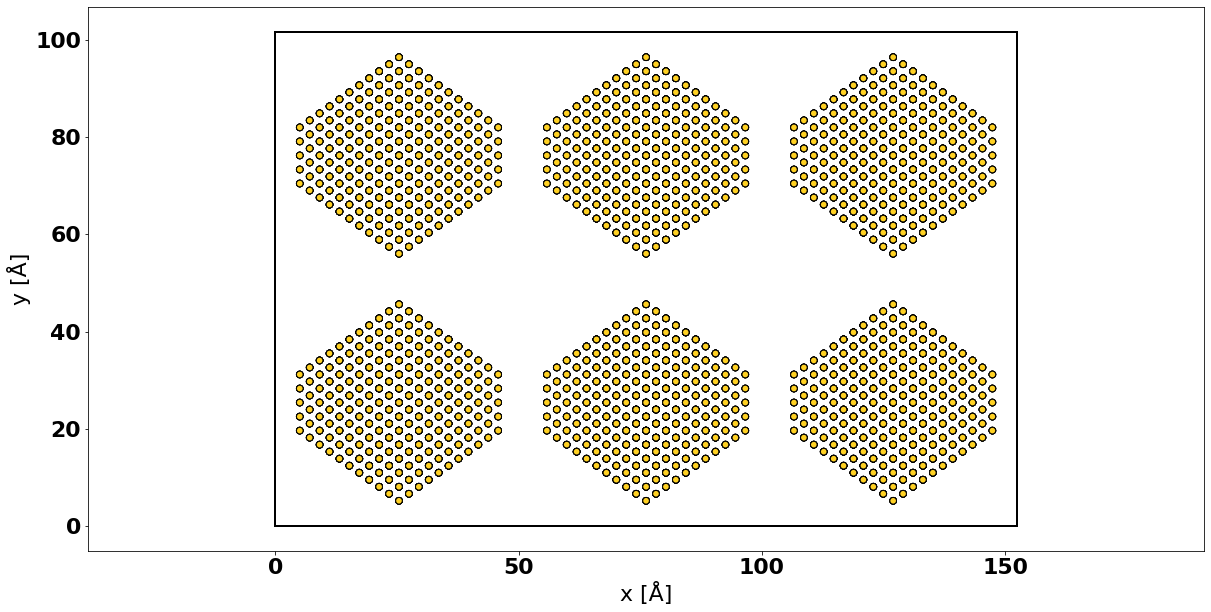

In [3]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)] # Nanoparticle facets

esurf = [1.0, 1.1, 0.9] # Relative surface energies

size = 2000 # Target number of atoms

atoms = Atoms(wulff_construction('Au', surfaces, esurf, size, 'fcc', rounding='above'))

atoms.center(vacuum=5)

atoms.rotate(45, 'x', center='cop')

atoms=atoms*(3,2,1)

show_atoms(atoms)

We create the electrostatic potential. In this example, we use the infinite projection scheme to allow the notebook to run with low computational resources. The sampling used here is also a bit rough.

In [4]:
potential = Potential(atoms, 
                      #gpts=64, 
                      sampling=0.5, 
                      slice_thickness=1, 
                      parametrization='kirkland', 
                      projection='infinite')

potential.sampling

(0.4996721311475409, 0.5004926108374383)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f5cbf6ecee0>)

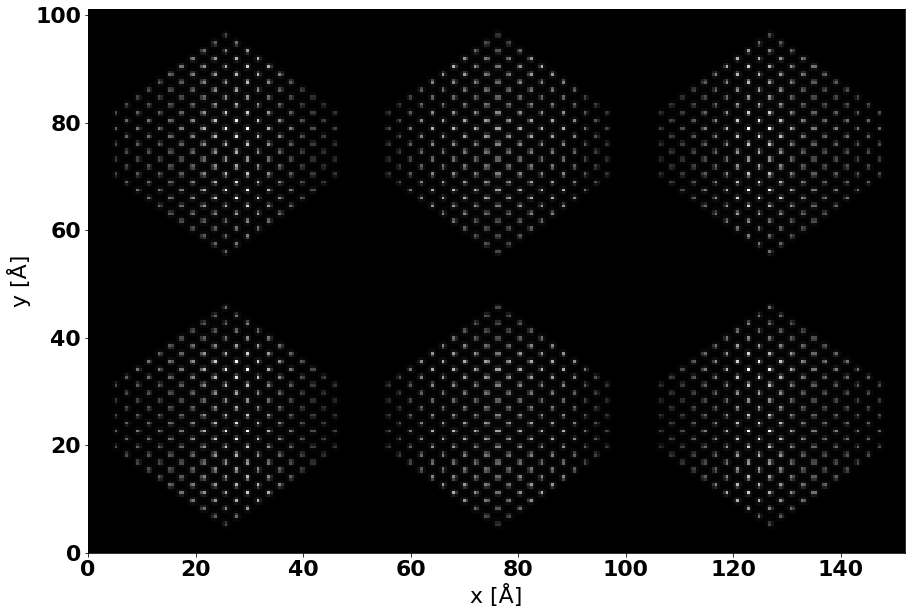

In [5]:
potential.build().project().show()

We create the incoming plane wave and start the multislice simulation.

In [6]:
from abtem.custom import get_potential
energy=200e3

potential = get_potential(phase_shift=np.pi/2,extent=np.array([1e-8/1e-10,1e-8/1e-10]),energy=energy,gpts=np.array([2048,2048]),num=1)

[0.04882812 0.04882812]


In [7]:
wave = PlaneWave(
    energy=energy # acceleration voltage in eV
)

exit_wave = wave.multislice(potential)

Multislice:   0%|          | 0/1 [00:00<?, ?it/s]

We can get the complex exit wave function as an array. Note, when temperature effects are included, we get out a stack of exit waves by default, one for each frozen phonon configuration.

In [8]:
print(exit_wave.array.shape, exit_wave.array.dtype)

(1, 2048, 2048) complex64


We show the intensity of the first exit wave and the intensity of the thermal ensemble. To get get the intensity of the thermal ensemble, we take the mean across the ensemble dimension after calculating the intensity.

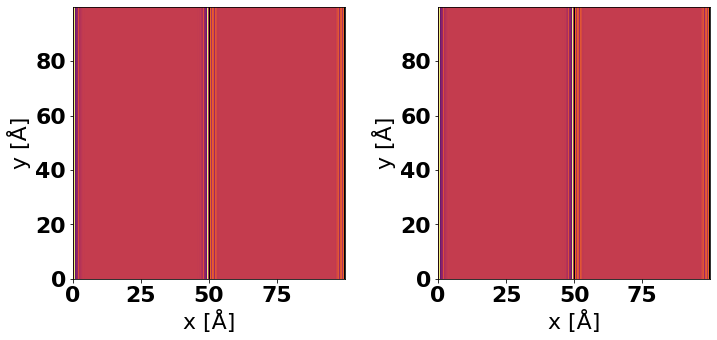

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
exit_wave.intensity().show(figsize=(6,6), ax=ax1, cmap='inferno');
exit_wave.intensity().mean(0).show(figsize=(6,6), ax=ax2, cmap='inferno');

We create and show the contrast transfer function, see [docs](https://abtem.readthedocs.io/en/latest/walkthrough/05_contrast_transfer_function.html) for a description of the parameters.

In [215]:
#temporal coherrence
C3 = 1.2e-3/1e-10 #In Angstrom
Cc = 1.61e-3/1e-10 # In Angstrom
focal_spread=Cc*(0.6/energy)
#spatial coherrence parameters
reduced_brightness=2e8 
I=10e-12 
defocus = scherzer_defocus(Cs=C3,energy=energy)

aperture=DeviatedAnularAperture(aperture_angle=10.6, energy=None, x_0=0, y_0=0,inner_aperture_angle=0, spokes = 0, spoke_thickness=1,fnc= lambda al, ph : np.exp(np.heaviside(al-0.3e-3,1)*1*np.pi/2*1j))
#aperture=DeviatedAnularAperture(aperture_angle=10.6, energy=None, x_0=0, y_0=0,inner_aperture_angle=0, spokes = 0, spoke_thickness=1,fnc= lambda al, ph : np.exp(1*np.pi/2*1j))
#aperture=DeviatedAnularAperture(aperture_angle=10.6, energy=None, x_0=0, y_0=0,inner_aperture_angle=0, spokes = 0, spoke_thickness=1,fnc= lambda al, ph : np.exp(np.heaviside(abs(ph)-np.pi/2,1)*np.pi/2*1j))

ctf = CTF(
    aperture=aperture,
    energy = wave.energy,
    semiangle_cutoff = 10.6, # mrad
    focal_spread = 0, # Å
    defocus = defocus, # Å
    Cs = C3, # Å
    rolloff=0.5
)


#ctf = CTF(energy=100e3, **{'defocus':10})

#ctf.show(max_semiangle=15);

In [216]:
np.heaviside(0.005-0.003,0)

1.0

In [217]:
alpha, phi = exit_wave.get_scattering_angles()
imshow_direct(np.angle(ctf.evaluate_aperture(alpha,phi)))

phi: [[ 0.          0.          0.         ...  3.1415927   3.1415927
   3.1415927 ]
 [ 1.5707964   0.7853982   0.4636476  ...  2.819842    2.6779451
   2.3561945 ]
 [ 1.5707964   1.1071488   0.7853982  ...  2.55359     2.3561945
   2.0344439 ]
 ...
 [-1.5707964  -1.2490457  -0.98279375 ... -2.3561945  -2.158799
  -1.8925469 ]
 [-1.5707964  -1.1071488  -0.7853982  ... -2.55359    -2.3561945
  -2.0344439 ]
 [-1.5707964  -0.7853982  -0.4636476  ... -2.819842   -2.6779451
  -2.3561945 ]]
alpha: [[0.         0.00025079 0.00050159 ... 0.00075238 0.00050159 0.00025079]
 [0.00025079 0.00035468 0.00056079 ... 0.00079308 0.00056079 0.00035468]
 [0.00050159 0.00056079 0.00070935 ... 0.00090425 0.00070935 0.00056079]
 ...
 [0.00075238 0.00079308 0.00090425 ... 0.00106403 0.00090425 0.00079308]
 [0.00050159 0.00056079 0.00070935 ... 0.00090425 0.00070935 0.00056079]
 [0.00025079 0.00035468 0.00056079 ... 0.00079308 0.00056079 0.00035468]]


phi: [[ 0.          0.          0.         ...  3.1415927   3.1415927
   3.1415927 ]
 [ 1.5707964   0.7853982   0.4636476  ...  2.819842    2.6779451
   2.3561945 ]
 [ 1.5707964   1.1071488   0.7853982  ...  2.55359     2.3561945
   2.0344439 ]
 ...
 [-1.5707964  -1.2490457  -0.98279375 ... -2.3561945  -2.158799
  -1.8925469 ]
 [-1.5707964  -1.1071488  -0.7853982  ... -2.55359    -2.3561945
  -2.0344439 ]
 [-1.5707964  -0.7853982  -0.4636476  ... -2.819842   -2.6779451
  -2.3561945 ]]
alpha: [[0.         0.00025079 0.00050159 ... 0.00075238 0.00050159 0.00025079]
 [0.00025079 0.00035468 0.00056079 ... 0.00079308 0.00056079 0.00035468]
 [0.00050159 0.00056079 0.00070935 ... 0.00090425 0.00070935 0.00056079]
 ...
 [0.00075238 0.00079308 0.00090425 ... 0.00106403 0.00090425 0.00079308]
 [0.00050159 0.00056079 0.00070935 ... 0.00090425 0.00070935 0.00056079]
 [0.00025079 0.00035468 0.00056079 ... 0.00079308 0.00056079 0.00035468]]


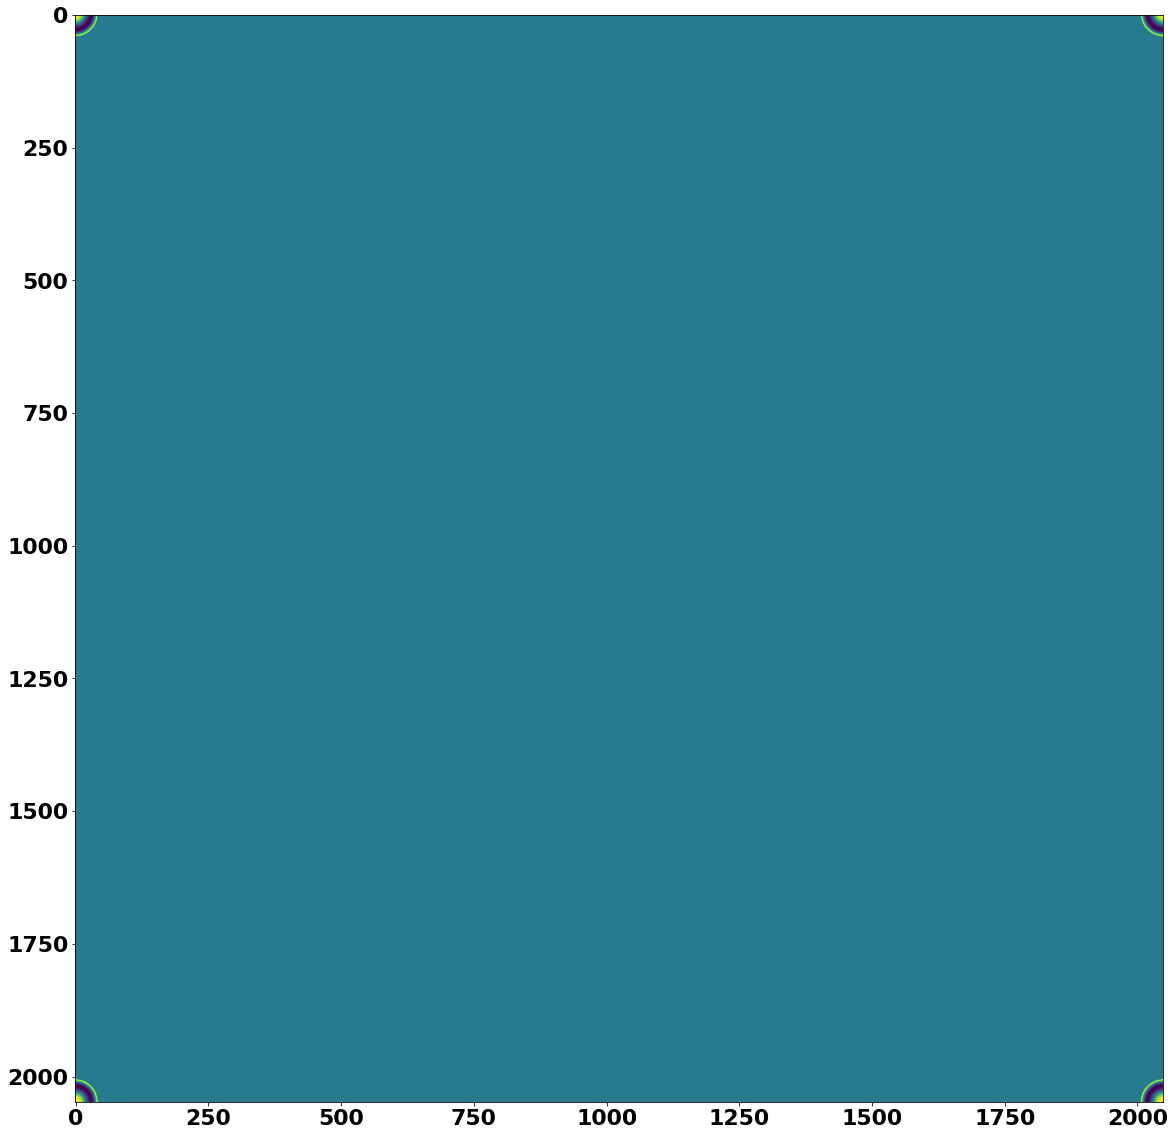

In [218]:
imshow_direct(np.imag(ctf.evaluate(alpha,phi)))

In [219]:
ctf.evaluate_aperture(np.array([0.001]),np.array([1e-3]))

phi: [0.001]
alpha: [0.001]


array([6.123234e-17+1.j], dtype=complex64)

To simulate an image we apply the contrast transfer function of the objective lens. 

phi: [[ 0.          0.          0.         ...  3.1415927   3.1415927
   3.1415927 ]
 [ 1.5707964   0.7853982   0.4636476  ...  2.819842    2.6779451
   2.3561945 ]
 [ 1.5707964   1.1071488   0.7853982  ...  2.55359     2.3561945
   2.0344439 ]
 ...
 [-1.5707964  -1.2490457  -0.98279375 ... -2.3561945  -2.158799
  -1.8925469 ]
 [-1.5707964  -1.1071488  -0.7853982  ... -2.55359    -2.3561945
  -2.0344439 ]
 [-1.5707964  -0.7853982  -0.4636476  ... -2.819842   -2.6779451
  -2.3561945 ]]
alpha: [[0.         0.00025079 0.00050159 ... 0.00075238 0.00050159 0.00025079]
 [0.00025079 0.00035468 0.00056079 ... 0.00079308 0.00056079 0.00035468]
 [0.00050159 0.00056079 0.00070935 ... 0.00090425 0.00070935 0.00056079]
 ...
 [0.00075238 0.00079308 0.00090425 ... 0.00106403 0.00090425 0.00079308]
 [0.00050159 0.00056079 0.00070935 ... 0.00090425 0.00070935 0.00056079]
 [0.00025079 0.00035468 0.00056079 ... 0.00079308 0.00056079 0.00035468]]


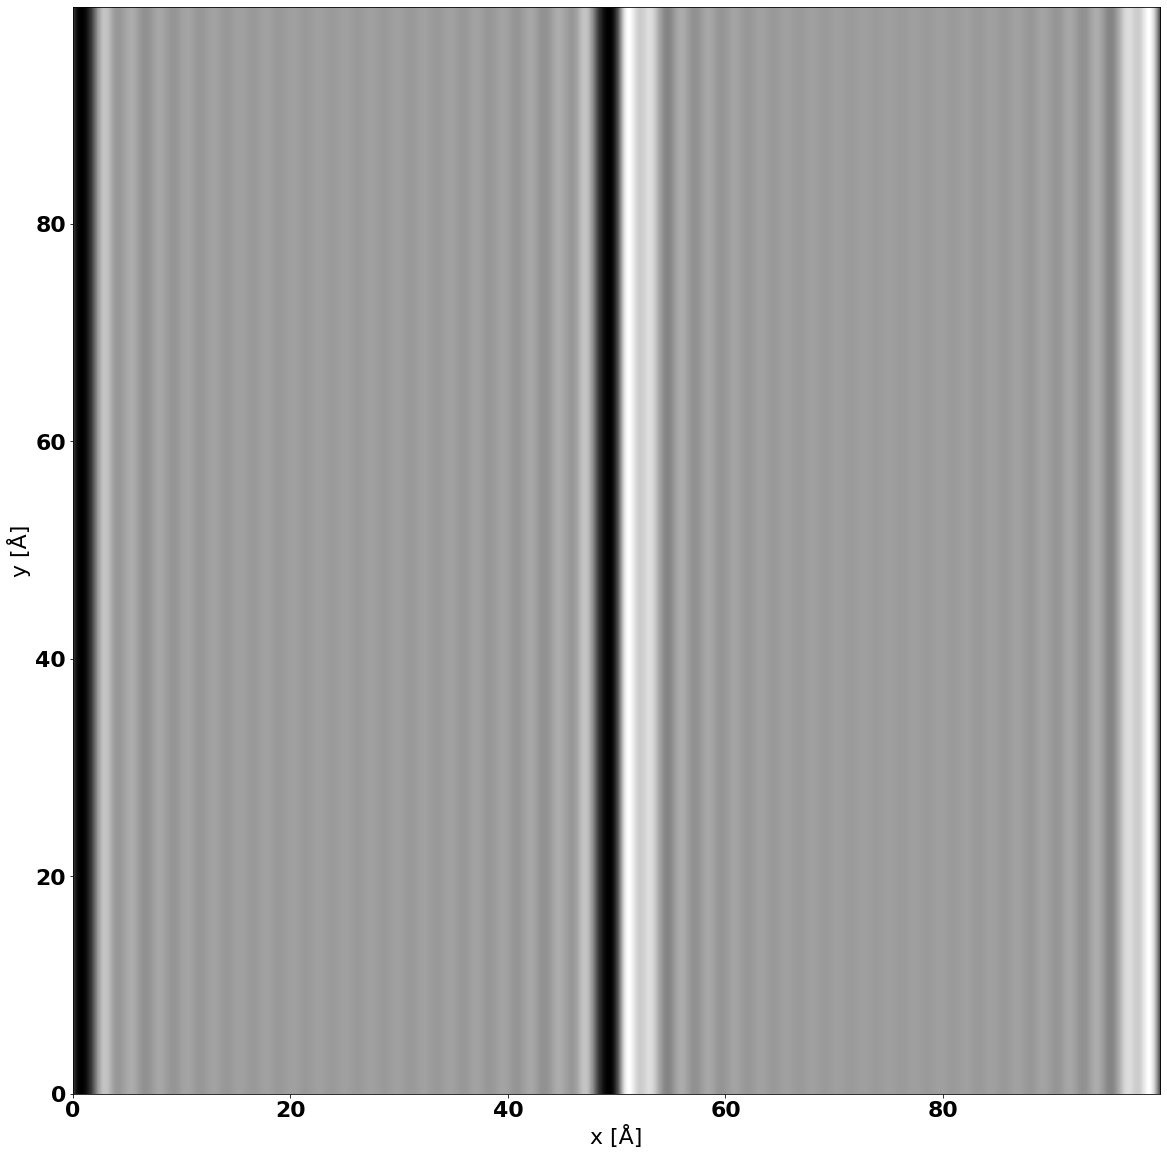

In [220]:
#%matplotlib qt
image_wave = exit_wave.apply_ctf(ctf)

image_wave.intensity().mean(0).show();

We can get the diffraction pattern up to a chosen scattering angle, we can block the zero order spot and display it on a power scale.

In [204]:
image_wave.diffraction_pattern(max_angle=30, block_zeroth_order=2, ).show(power=.3);

We can add noise to image, here using a basic Poisson model.

In [205]:
from abtem.noise import poisson_noise

measurement = image_wave.intensity()
noisy_measurement = poisson_noise(measurement, 5000)

noisy_measurement.show();